In [1]:
%reload_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%matplotlib inline
  
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Learning and reproduction of gestures by demonstration [1]

### Algorithms for Imitation Learning, Marc Tuscher
 
[1] Calinon et al. (https://www.idiap.ch/~scalinon/papers/Calinon-RAM2010.pdf)

# Learning and reproduction of gestures by demonstration
## Outline

- Background
    - Gaussian Mixture Models
- Programming by Demonstration
    - Approach
    - Benefits & Drawbacks
    - Demo
    - Results
    

### Gaussian Mixture Models

- method for clustering data
- $K$ different Gaussians with parameters $\mu_k$, $\Sigma_k$
- Expectation-Maximization Algorithm:
    - initialize randomly
    - E-step: (soft-assignment)
    $$q(c_i = k) = P(c_i = k | x_i, \mu_{1;K}, \Sigma_{1:K}) \propto  \mathcal{N}(x_i | \mu_k, \Sigma_k) \pi_k$$
    - M-step: update parameters
    $$\pi_k = \frac{1}{n}\sum_i q(c_i = k)$$
    $$\mu_k = \frac{1}{n \pi_k} \sum_i q(c_i = k) x_i$$
    $$\Sigma_K = \frac{1}{n\pi_k} \sum_i q(ci=k) x_i x_i^T -\mu_k\mu_k^T$$
(https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/19-MachineLearning/06-unsupervised.pdf)

(200, 2)


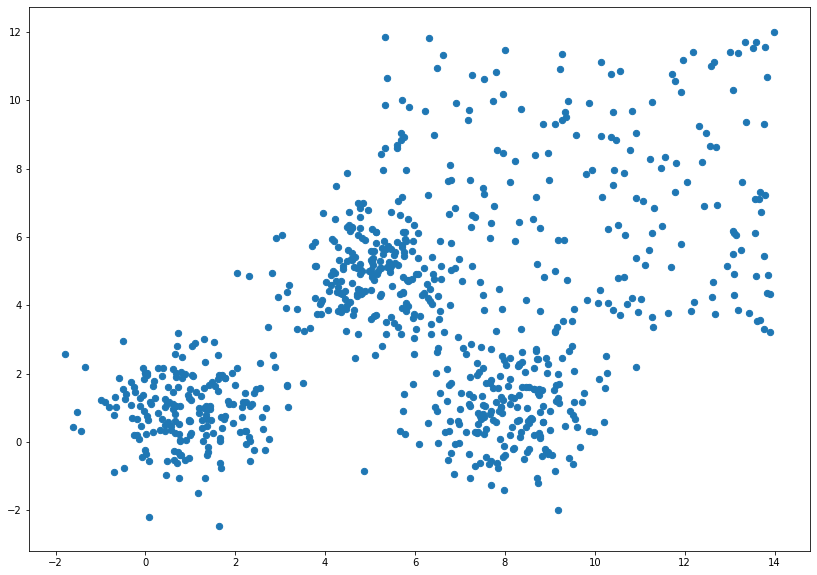

In [3]:
center_1 = np.array([1,1])
center_2 = np.array([5,5])
center_3 = np.array([8,1])
center_4 = np.array([4,2])

# Generate random data and center it to the three centers
data_1 = np.random.randn(200, 2) + center_1
data_2 = np.random.randn(200,2) + center_2
data_3 = np.random.randn(200,2) + center_3
data_4 = np.random.uniform(1.2, 10, size=(200, 2)) + center_4
print(data_4.shape)

data = np.concatenate((data_1, data_2, data_3, data_4), axis = 0)
plt.figure(figsize=(14, 10))
plt.scatter(data[:,0], data[:,1], s=40)

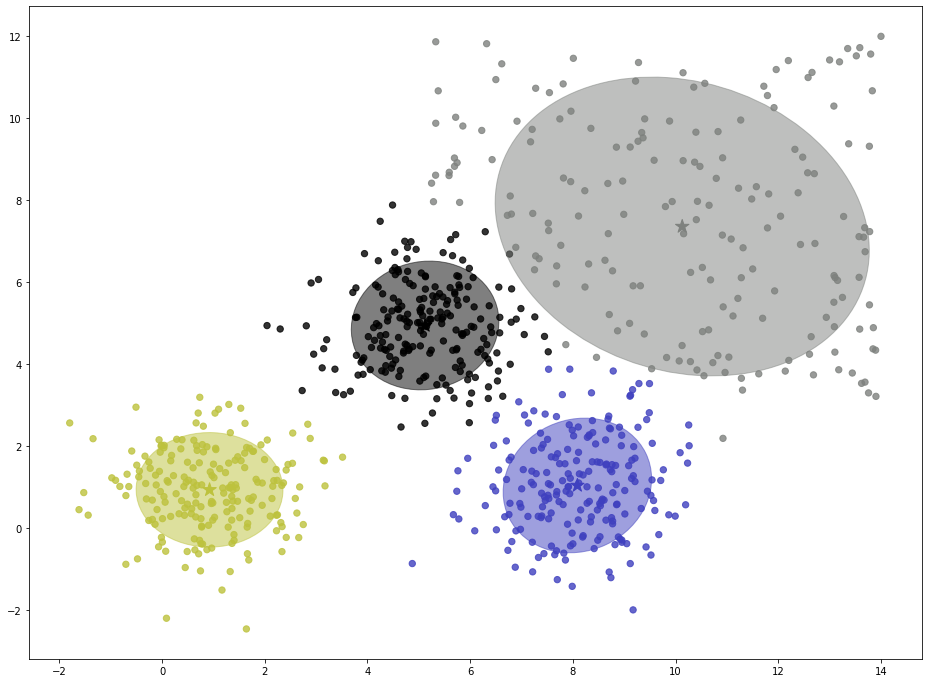

In [4]:
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
from matplotlib import colors as mcolors

def get_spaced_colors(n, opacity=1):
    max_value = 16581375 #255**3
    interval = int(max_value/ n )
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    return [(int(i[:2], 16)/255, int(i[2:4], 16)/255, int(i[4:], 16)/255, opacity) for i in colors]

def plot_gmm(n_clusters=4, max_iter=100):
    colors = get_spaced_colors(n_clusters)
    model = GaussianMixture(n_components=n_clusters, max_iter=max_iter)
    model.fit(data)
    y = model.predict(data)
    fig, ax = plt.subplots(figsize=(16,12))
    colors_y = list(map(lambda x: colors[x], y))
    plt.scatter(data[:, 0], data[:, 1], c=colors_y, s=40, alpha=0.8)
    centers = model.means_
    y_centers = model.predict(centers)
    colors_c = list(map(lambda x: colors[x], y_centers))
    plt.scatter(centers[:, 0], centers[:, 1], c=colors_c, s=200, marker="*")
    for i, (mean, covar) in enumerate(list(zip(model.means_, model.covariances_))):
        v, w = np.linalg.eigh(covar)
        v = 2* np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        angle =  180. * np.arctan(u[1]/u[0]) / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=colors_c[i])
        ell.set_clip_box(fig.bbox)
        ell.set_alpha(0.5)
        ax.add_patch(ell)
        

plot_gmm(n_clusters=4, max_iter=100)

## Learning and reproduction of gestures by demonstration 
### General considerations:

- directly learn low level controls $\phi: q \mapsto \dot{q}$
- learn the joint distribution of $q$ and $\dot q$ using GMMs
- capture sequential nature of a trajectory by using HMMs
- predict joint velocities given joint angles by gaussian mixture regression



##### directly learn low level controls $\phi: q \mapsto \dot{q}$
- <span style="color:orange">Alternative: </span> Symbolic Approach (e.g.: move there; grasp that)
    - <span style="color:red">Drawback: </span> symbolic approaches rely on biases to be segmented

##### learn the joint distribution of $q$ and $\dot q$ using GMMs
- <span style="color:green">Benefit: </span> good generalization to unseen regions
- <span style="color:orange">Alternative: </span> other approaches which consider modeling dynamics of motion
    - <span style="color:red">Drawback: </span> usually requires high number of states

##### capture sequential nature of a trajectory by using HMMs
- <span style="color:green">Benefit: </span> no direct time dependence
- <span style="color:orange">Alternative: </span> explicitly model time dependence
    - <span style="color:red">Drawback: </span> Aligning and scaling time dependend sequences is difficult

##### predict velocities given positions by gaussian mixture regression
- <span style="color:green">Benefit: </span> select input and output components at inference time
- <span style="color:green">Benefit: </span> handle different sources of missing data
- <span style="color:orange">Alternative: </span> direct regression (e.g. Gaussian Process Regression)
    - <span style="color:red">Drawback: </span> input and outputs fixed, no choice at inference time

### Theoretical approach: training procedure

- a skill is demonstrated to the robot in slightly different situations
- demonstration $m \in \{1, ..., M\}$ consists of a set of Trajectories $T_m$
- Trajectory $T_m$ consists of $d$-dimensional joint positions $x$ and velocities $\dot{x}$ 

$$D = \{\{(x_t, \dot{x}_t)\}_{t=1}^T\}_{m=1}^M$$

- joint distribution $\mathcal{P}(x, \dot{x})$ is encoded in a continuous HMM $H$ of $K$ states: 

$$ H = \{\Pi, a, \mu, \Sigma\}$$

- learned using Baum-Welch Algorithm(variant of the expectation maximization algorithm)
- Input and output components of HMM in each state $s_i$:

$$\mu_i = \left[\begin{array}{c}\mu_i^x \\ \mu_i^{\dot{x}}\end{array}\right] \text{, } \Sigma_i = \left[\begin{array}{cc}\Sigma_i^x & \Sigma_i^{x\dot{x}}\\ \Sigma_i^{\dot{x}x}& \Sigma_i^{\dot{x}}\end{array}\right] $$

### Theoretical approach: prediction
- given the current joint positions, a desired velocity command is estimated using gaussian mixture regression

$$\hat{\dot{x}} = \sum_{i=1}^K h_i(x) [ \mu_i^{\dot{x}} + \Sigma_i^{\dot{x}x}(\Sigma_i^x)^{-1} (x - \mu_i^x)]$$

- where $h_i(x)$ is used to encode the sequential information encapsulated in the HMM:

$$h_i(x_t) = \frac{(\sum_{j=1}^K h_j(x_{t-1}) a_{ji}) \mathcal{N}(x_t; \mu_i^x, \Sigma_i^x)}{\sum_{k=1}^K [(\sum_{j=1}^K h_j(x_{t-1}) a_{jk})\mathcal{N}(x_t; \mu_k^x, \Sigma_k^x)]}$$




- since reproduction is unstable in regions that have not been covered during the demonstration, a secondary term has to be added:

$$\hat{x} = \sum_{i=1}^K h_i(x) [ \mu_i^{x} + \Sigma_i^{x\dot{x}}(\Sigma_i^\dot{x})^{-1} (\dot{x} - \mu_i^\dot{x})]$$

- these terms contribute to an acceleration term which keeps the robot in known regions

$$\ddot{x} = (\hat{\dot{x}} - \dot{x}) \kappa^{\mathcal{V}} + (\hat{x}-x)\kappa^{\mathcal{P}} $$
![Damping with acc](images/damping.png)

In [6]:
%%HTML
<div align="middle">
<video width="90%" controls mute>
  <source src="videos/demo_zeros.mp4" type="video/mp4">
</video></div>

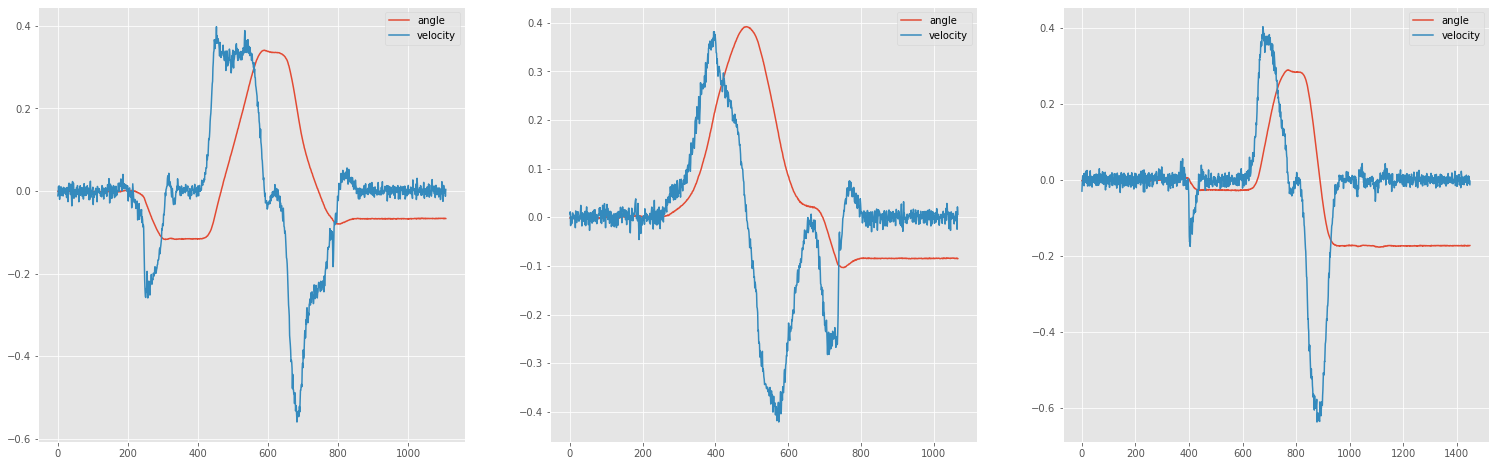

In [5]:
import pbdlib as pbd
import pickle
import os
import time
from collections import defaultdict
os.getcwd()

# load names of joints to map from ros 2 rai joints. Only relevant joints (of right arm) are loaded
with open('../bagfiles/names.pkl', 'rb') as f:
    names = pickle.load(f)

# load demonstration dataset type: List of np.array() with shape=(np_steps_in_trajectory, 2*dim(q))
with open('../bagfiles/demo_zero/dataset.pkl', 'rb') as f:
    demos = pickle.load(f)

joint_n = 3
fig, ax = plt.subplots(1, 3, figsize=(26, 8))
for i in range(len(demos)):
    ax[i].plot(demos[i][:, joint_n], label="angle")
    ax[i].plot(demos[i][:, joint_n + 7], label="velocity")
    ax[i].legend()

In [6]:
# initialize HMM model and train using expectation-maximization (already implemented in https://gitlab.idiap.ch/rli/pbdlib-python)
model = pbd.HMM(6, 14)

model.init_hmm_kbins(demos)

start_time = time.time()
model.em(demos, left_to_right=True, nb_max_steps=100)
training_time = time.time() - start_time

print("Training time: %f seconds" % training_time )

EM converges
Training time: 5.910849 seconds


Unfortunately, some functions for reproducing the demonstrated tasks were missing from the framework. So I added them. (I assume, the framework was made specifically for more recent papers.)

Predicting the next joint velocities to fulfill the task, given current joint angles:

$$\hat{\dot{x}} = \sum_{i=1}^K h_i(x) [ \mu_i^{\dot{x}} + \Sigma_i^{\dot{x}x}(\Sigma_i^x)^{-1} (x - \mu_i^x)]$$

In [9]:
from types import MethodType
# add datastructure to save previously computed values
model.qs = {}
model.hs = {}

# add missing function for q_dot prediction, given the trained hmm
def predict_qdot(self, q, t):
    q_dim = len(q)
    q_dot = np.zeros((q_dim))
    reset=False
    for i in range(self.nb_states):
        a = q - self.mu[i][:q_dim]
        b = np.linalg.inv(self.sigma[i][0:q_dim , 0:q_dim]) @ a
        c = self.sigma[i][q_dim:, 0:q_dim] @ b
        d = self.mu[i][q_dim:] + c
        if t == 0:
            reset = True
        h = self.online_forward_message(q, marginal=slice(0,7), reset=reset)
        self.hs[i, t] = h[i]
        q_dot += h[i] * d
    return q_dot

def marginal_model(self, dims):
    gmm = pbd.HMM(nb_dim=dims.stop-dims.start, nb_states=self.nb_states)
    gmm.priors = self.priors
    gmm.mu = self.mu[:, dims]
    gmm.sigma = self.sigma[:, dims, dims]
    return gmm

# bind to class methods (already bound in https://github.com/marctuscher/pbdlib) 
model.predict_qdot = MethodType(predict_qdot, model)
model.marginal_model = MethodType(marginal_model, model)

Predicting the next joint angles, given current joint angles and predicted joint velocities:
$$\hat{x} = \sum_{i=1}^K h_i(x) [ \mu_i^{x} + \Sigma_i^{x\dot{x}}(\Sigma_i^\dot{x})^{-1} (\dot{x} - \mu_i^\dot{x})]$$

In [11]:
def predict_q(self, q_dot, q, t):
    q_dim = len(q_dot)
    q_new = np.zeros((q_dim))
    for i in range(self.nb_states):
        a = q_dot - self.mu[i][q_dim:]
        b = np.linalg.inv(self.sigma[i][q_dim: , q_dim:]) @ a
        c = self.sigma[i][:q_dim, q_dim:] @ b
        d = self.mu[i][:q_dim] + c
        q_new += self.hs[i, t] * d
    return q_new

# bind to class methods (already bound in https://github.com/marctuscher/pbdlib) 
model.predict_q = MethodType(predict_q, model)

In [2]:
# the following cells will use the rai framework for robot control, simulation and motion planning
# https://github.com/MarcToussaint/rai
import sys
# add the folder where libry.so is located to the path. Otherwise the import will crash.
sys.path.append('../rai/rai/ry/')
import libry as ry
import time
import gc
import os
from collections import defaultdict
# add simulation. Note: if the string argument is not an empty string, a ROS node is started
# and the joint state topics of the real baxter are subscribed. This won't work if you can't connect to Baxter.
# In order to connect to Baxter, uncomment the next 2 lines and set the correct IP address:
#os.environ["ROS_MASTER_URI"] = "http://thecount.local:11311/"
#os.environ["ROS_IP"] = "129.69.216.204"

In [3]:
# clear views, config and operate by setting shared pointers to 0. Otherwise the notebook has to be restarted,
# which is pretty annoying.
C = 0
v = 0
B = 0
gc.collect()
    
# initialize config
C = ry.Config()
v = C.view()
C.clear()
C.addFile('../../robotics-course/rai-robotModels/baxter/baxter_new.g')



q_home = C.getJointState()
q_zero = q_home * 0.
B = C.operate('')
B.sync(C)
C.makeObjectsConvex()
right_joints = [name for name in C.getJointNames() if name.startswith('right')]

def get_joint_mapping():
    mapping = defaultdict(dict)
    print("RAI")
    for i, name in enumerate(C.getJointNames()):
        if name.startswith('right'):
            print("{} : {}".format(i, name))
            mapping[name]['rai'] = i
    print("ROS")
    i = 0
    for _, name in enumerate(names):
        if name.startswith('right'):
            print("{} : {}".format(i, name))
            mapping[name]['ros']=i
            i += 1
    return mapping

mapping = get_joint_mapping()
B.moveHard(q_zero)

RAI
1 : right_s0
3 : right_s1
5 : right_e0
7 : right_e1
9 : right_w0
11 : right_w1
13 : right_w2
ROS


NameError: name 'names' is not defined

In [12]:
def plan_trajectory(model, kappa_p=0.3, steps=50, timePerPhase=1, q_dot_scale=.5, q_ddot_scale=.5):
    """ 
    Because there is no possibilty to directly send q_dot controls to the robot, the komo path planner is
    used to apply the computed positions, velocities and accelerations for a single timestep.
    
    WARNING: Despite having some nice properties (e.g. collision avoidance) this method is super sensitive 
    to specific parameters.
    """
    B.sync(C)
    ik_path = C.komo_path(1, 2, timePerPhase, False)
    path = []
    times = []
    trajectory = []
    currentTime = 0
    q_rai = C.getJointState()
    retrieval_time = 0
    for t in range(steps):
        ik_path.setConfigurations(C)
        q = np.zeros((7, ))
        for name in right_joints:
            q[mapping[name]['ros']] = q_rai[mapping[name]['rai']]
        start_time = time.time()
        q_dot = model.predict_qdot(q, t)
        retrieval_time += time.time() - start_time
        q_new = model.predict_q(q_dot, q, t)
        q_dot_rai = np.zeros((17,))
        q_ddot_rai = np.zeros((17,))
        q_ddot = kappa_p * (q - q_new)
        for name in right_joints:
            q_rai[mapping[name]['rai']] = q_new[mapping[name]['ros']]
            q_dot_rai[mapping[name]['rai']] = q_dot[mapping[name]['ros']]
            q_ddot_rai[mapping[name]['rai']] = q_ddot[mapping[name]['ros']]
        ik_path.clearObjectives()
        ik_path.addObjective(feature=ry.FS.qItself, order=0, target=q_rai, type=ry.OT.sos, scale=[1])
        ik_path.addObjective(feature=ry.FS.qItself, order=1, target=q_dot_rai, type=ry.OT.sos, scale=[q_dot_scale])
        ik_path.addObjective(feature=ry.FS.qItself, order=2, target=q_ddot_rai, type=ry.OT.sos, scale=[q_ddot_scale])
        ik_path.optimize(False)
        C.setFrameState(ik_path.getConfiguration(1))
        q_rai = C.getJointState()
        path.append(q_rai)
        currentTime += timePerPhase
        times.append(currentTime)
        trajectory.append(np.concatenate([q, q_dot]))
    return (path, times), trajectory, retrieval_time/steps

In [13]:
B.moveHard(q_zero)
(path, times), trajectory, retrieval_time = plan_trajectory(model, kappa_p=0.3, steps=600, timePerPhase=1, q_dot_scale=0.24, q_ddot_scale=1)

In [14]:
# oscilating around the goal, as stated in the paper
B.move(path, np.array(times)/30, False)

In [15]:
%%HTML
<div align="middle">
<video width="90%" controls mute>
  <source src="videos/rep_zeros.mp4" type="video/mp4">
</video></div>

In [16]:
# PCA on demonstrations
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_trajectory(data):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(data[:, 0], data[:, 1], data[:, 2])

pca_demo = PCA(3)
tfd_demo = pca_demo.fit_transform(demos[2])

pca_trajectory = PCA(3)
tfd_traj = pca_trajectory.fit_transform(trajectory)


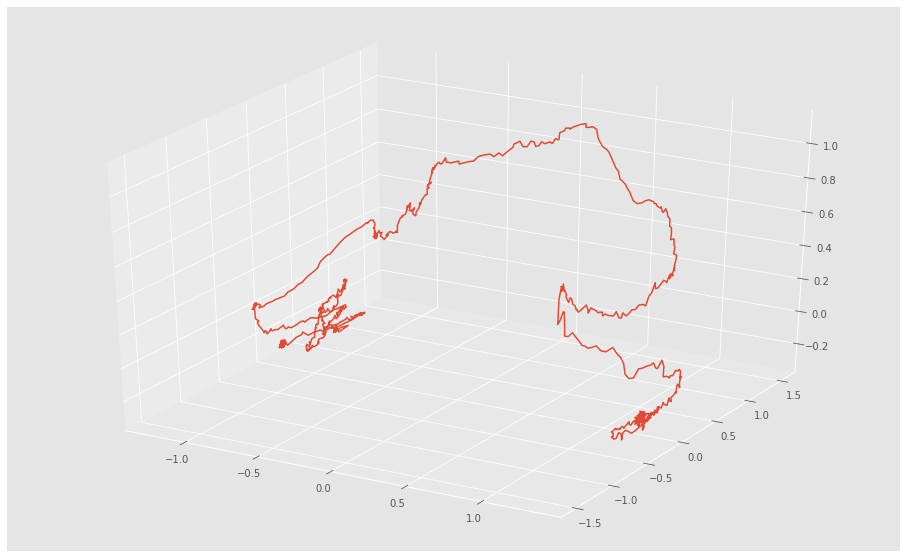

In [17]:
plot_3d_trajectory(tfd_demo)

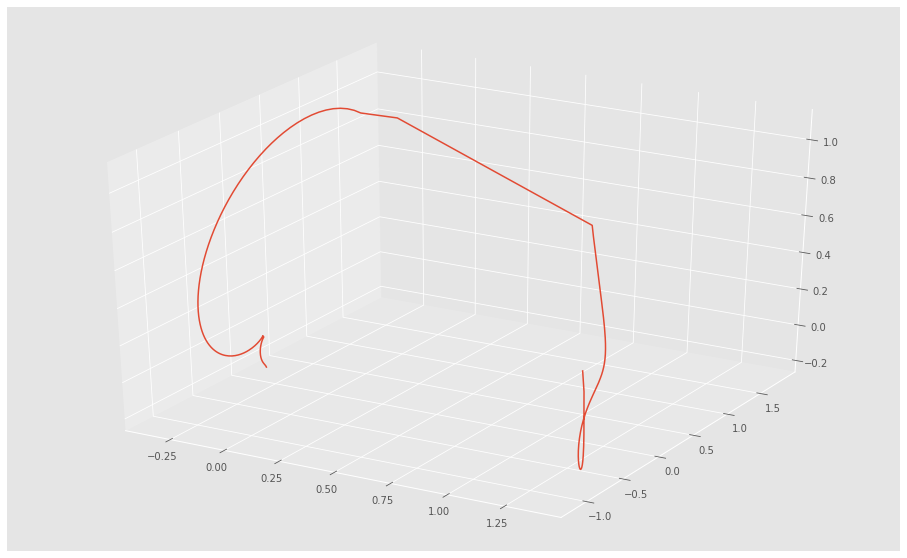

In [18]:
plot_3d_trajectory(tfd_traj)

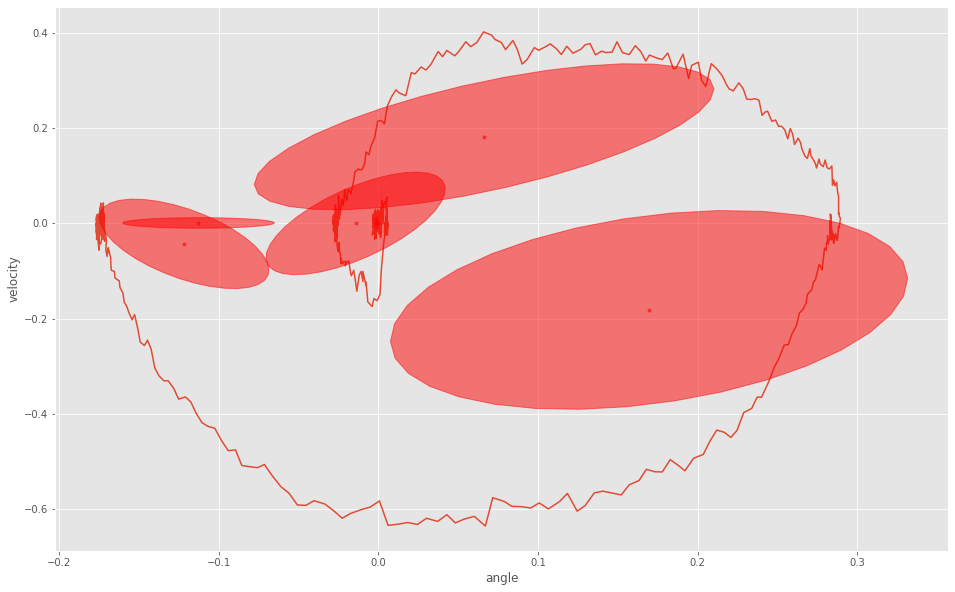

In [19]:
dim = 3
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot()
ax.plot(demos[2][:, dim], demos[2][:, dim + 7])
plt.xlabel("angle")
plt.ylabel("velocity")

pbd.plot_gmm(model.mu, model.sigma, dim=[dim, dim + 7])

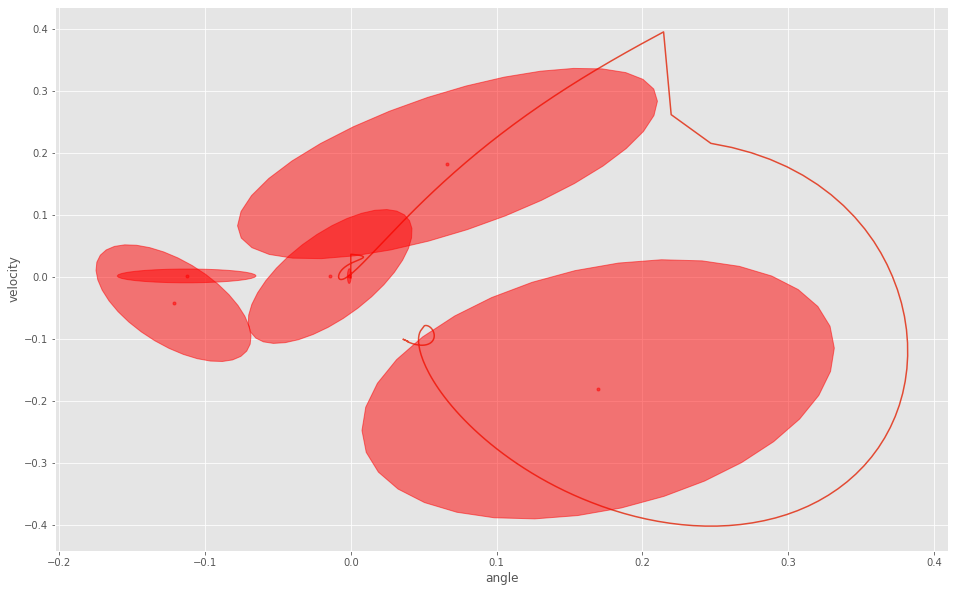

In [20]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot()
trajectory = np.array(trajectory)
ax.plot(trajectory[:, dim], trajectory[:, dim + 7])
plt.xlabel("angle")
plt.ylabel("velocity")

pbd.plot_gmm(model.mu, model.sigma, dim=[dim, dim + 7])

Text(0.5, 0, 'timestep')

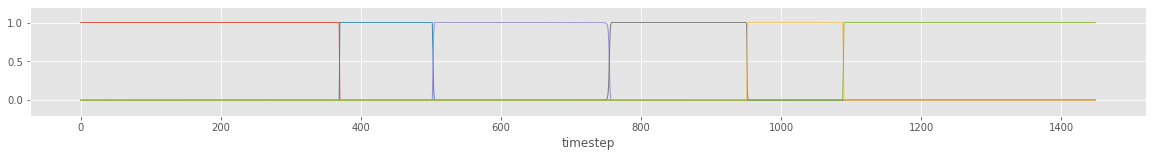

In [21]:
alpha_hmm, _, _, _, _ = model.compute_messages(demos[2][:, :7], marginal=slice(0, 7))
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot()
ax.plot(alpha_hmm.T, lw=1)
ax.set_ylim([-0.2, 1.2])
plt.xlabel('timestep')

### Metrics
- M1: RMS error along the motion w.r.t to the demonstration dataset  M_1

- M2: RMS error after DTW

- M3: Norm of jerk; derivative of acceleration is a good candidate to evaluate the smoothness of human motion

- M4: Computation time of learning process

- M5: Retrieval duration

In [41]:
from dtw import dtw

dist_func = lambda x, y: np.sqrt(np.linalg.norm(x - y)**2)
mean_norm = 0
mean_dtw_norm = 0
for n in range(len(demos)):
    norm = np.sqrt(np.linalg.norm(demos[n][len(trajectory)] - trajectory))
    c, cost_matrix, acc_cost_matrix, path = dtw(demos[n], trajectory, dist=dist_func)
    mean_norm += norm
    mean_dtw_norm += c

mean_norm /= len(demos)
mean_dtw_norm /= len(demos)


print("M1: RMS: %f" % mean_norm)
print("M2: RMS after DTW: %f" % mean_dtw_norm)
print("M4: Training time: %f seconds" % training_time)
print("M5: Retrieval time: %f milliseconds, rate: %f hz" % ((retrieval_time * 1000), 1/retrieval_time))

M1: RMS: 5.293444
M2: RMS after DTW: 0.390247
M4: Training time: 12.944575 seconds
M5: Retrieval time: 15.857896 milliseconds, rate: 63.060070 hz


### Influence of number of states and dataset size

<center>Number of states</center> |  <center>Number of demos</center>
:-------------------------:|:-------------------------:
![](images/number_of_states.png)  |  ![](images/number_of_trajectories.png)


### Crossing points in trajectories

![](images/crossing_points.png)

### Other Experiments

- playing table tennis
- feeding a doll

![experiments](images/experiments.png)

### Playing table tennis

- HMM model can handle different trajectories
- without any classification the system inferes the correct trajectory from a starting point
- model generates correct velocity (magnitude and direction)
![crossing_points](images/different_trajectories.png)

### Feeding a doll

- 2 landmarks (plate and mouth)
- learn a HMM for each landmark
- combine by multiplying gaussians
- strong consistency where motion needs to be accurate

![](images/landmarks.png)

# Thanks for your attention.

## Questions?

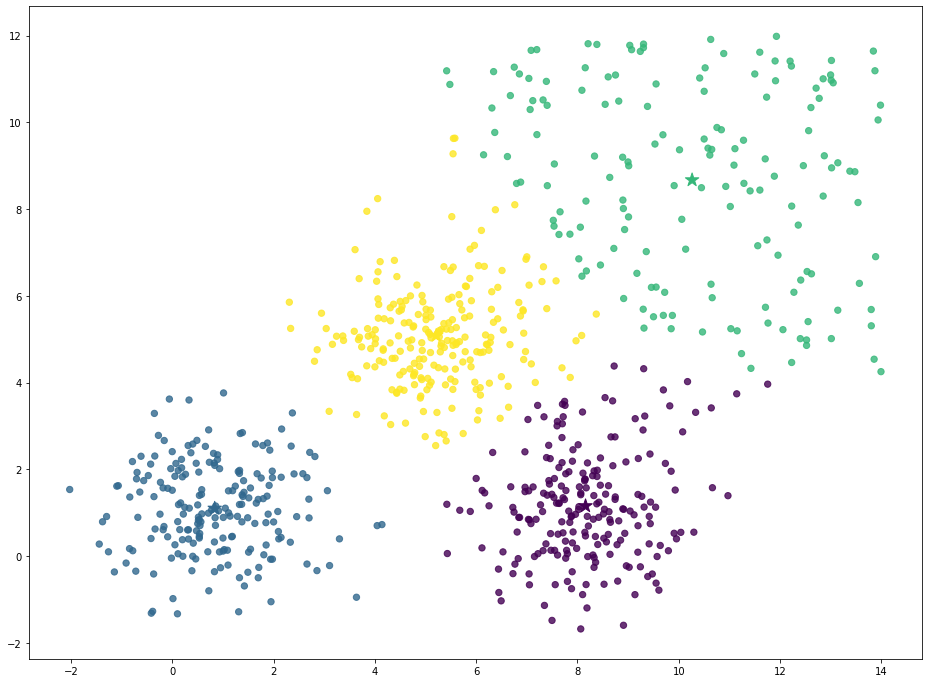

In [4]:
from sklearn.cluster import KMeans

def plot_kmeans_model(n_clusters=4, max_iter=100):
    model = KMeans(n_clusters=n_clusters, max_iter=max_iter)
    model.fit(data)
    y = model.predict(data)
    plt.figure(figsize=(16,12))
    plt.scatter(data[:, 0], data[:, 1], c=y, s=40, alpha=0.8)
    centers = model.cluster_centers_
    y_centers = model.predict(centers)
    plt.scatter(centers[:, 0], centers[:, 1], c=y_centers, s=200, marker="*")


plot_kmeans_model()

### Results


- HMM vs TMGR (Time dependent gaussian mixture regression): 

- M1 & M2: all methods perform well, HMM performs well with a small number of states

- M3: HMM is a little bit jerky

- M4: training time is less important than reproduction time

- M5: LWR not competitable; linear dependencs in the number of states

- when dimensionality is low, the difficulty is to correctly handle the crossing points that can appear when randomly generating trajectories


### Hidden Markov Models

- joint distribution 

$$P(X_{0:T}, Y_{0:T}) = P(X_0) \cdot \prod_{t=1}^T P(X_{t}| X_{t-1}) \cdot \prod_{t=0}^T P(Y_{t}| X_{t})$$

https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/18-ArtificialIntelligence/10-dynamicalModels.pdf

iteration  1 / 10
iteration  2 / 10
iteration  3 / 10
iteration  4 / 10
iteration  5 / 10
iteration  6 / 10
iteration  7 / 10
iteration  8 / 10
iteration  9 / 10
iteration  10 / 10


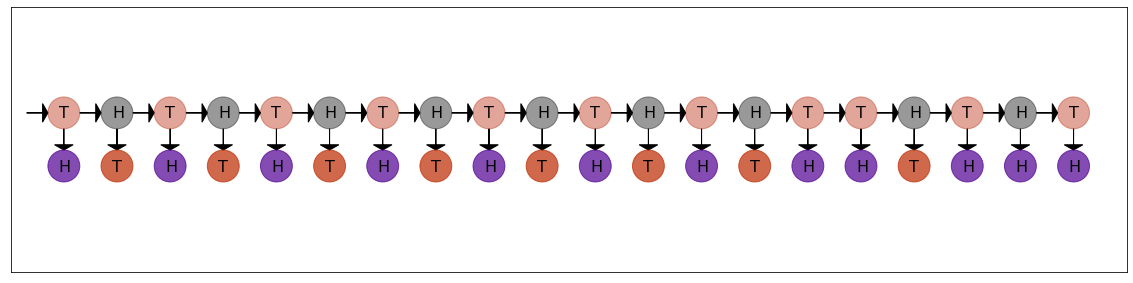

In [6]:
import hmms

def train_random_hmm(data, cats={"H": 0, "T": 1}):
    dhmm = hmms.DtHMM.random(2,2)
    data = data.copy()
    for i in range(len(data)):
        data[i] = np.array(list(map(lambda x: int(cats[x]), data[i])))
    data = data.astype(np.int)
    dhmm.baum_welch(data, 10)
    return dhmm
cats={"H": 0, "T": 1}
inv_cats = {v: k for k, v in cats.items()}

data = np.array([
    ["H", "T", "H", "H", "H", "H", "T"],
    ["H", "H", "T", "H", "T", "H", "T"],
    ["H", "T", "H", "H", "T", "H", "T"],
])

hmm = train_random_hmm(data)
# Create DtHMM by given parameters.
seq, e_seq = hmm.generate(20)
#resize plot
plt.rcParams['figure.figsize'] = [20,20]
hmms.plot_hmm(seq, e_seq , cats=inv_cats)


e_seq = ["H", "T", "T", "H", "H"]

# Backlog

- GMM
    - kmeans + gmm(https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/19-MachineLearning/06-unsupervised.pdf)
    - kmeans implementation (https://www.kaggle.com/andyxie/k-means-clustering-implementation-in-python)
- HMM
    - hmm theoretical (https://ipvs.informatik.uni-stuttgart.de/mlr/marc/teaching/18-ArtificialIntelligence/09-graphicalModels.pdf)
    - hmm implementation heads + tails (https://github.com/ananthpn/pyhmm)
    - cont time and discrete time plots (https://github.com/lopatovsky/HMMs)
    - hmm robo filtering (https://github.com/beneisnr/hMm-filtering)
- DTW

- pbdlib
    - Related Work:
    - no symbolic approach (look up "Natural methods for robot task learning: Instructive demonstrations, generalization and practice")
        - DRAWBACK: symbolic approaches rely on biases to be segmented
    - no direct time dependence
        - DRAWBACK: Algining and scaling time dependet sequences is a difficult task (handling spatial and temporal perturbances is hard)
    - other approaches have considererd modeling the intrinsic dynamics of motion
        - BENEFIT: does not depent on explicit time variable
        - BENEFIT: can be modulated in unseen regions
        - DRAWBACK: require high number of states and smooting procedure
    - propsed model: HMMs and GMMs
    - GMR models joint probability function of the data (no direct regression like gpr)
    - regression function is then derived from the joint density model
        - ADVANTAGE: input and output components are only specified at the very last step of the process
        - ADVANTAGE: density estimation can be learning in an off-line phase, regression process can be computed very rapidly
        - ADVANTAGE: can handle different sources of missing data: system can consider any combination of input/output mappings

## Approach

- a skill is demonstrated to the robot in slightly different situations
- demonstration $m \in \{1, ..., M\}$ consists of a set of Trajectories $T_m$
- Trajectory $T_m$ consists of $d$-dimensional joint positions $x$ and velocities $\dot{x}$ 

$$D = \{\{(x_t, \dot{x}_t)\}_{t=1}^T\}_{m=1}^M$$

- joint distribution $\mathcal{P}(x, \dot{x})$ is encoded in a continuous HMM of K states.
- output distribution of each state is represented by a gaussian which encodes local variation and correlation information
- Parameters of HMM:

$$\{\Pi, a, \mu, \Sigma\}$$

- learned using Baum-Welch Algorithm(variant of the expectation maximization algorithm)
- Input and output components of HMM in each state $s_i$:

$$\mu_i = \left[\begin{array}{c}\mu_i^x \\ \mu_i^{\dot{x}}\end{array}\right] \text{, } \Sigma_i = \left[\begin{array}{cc}\Sigma_i^x & \Sigma_i^{x\dot{x}}\\ \Sigma_i^{\dot{x}x}& \Sigma_i^{\dot{x}}\end{array}\right] $$

- given the current position command, a desired velocity command is estimated using gaussian mixture regression

$$\hat{\dot{x}} = \sum_{i=1}^K h_i(x) [ \mu_i^{\dot{x}} + \Sigma_i^{\dot{x}x}(\Sigma_i^x)^{-1} (x - \mu_i^x)]$$

- where $h_i(x)$ is used to encode the sequential information encapsulated in the HMM:

$$h_i(x_t) = \frac{(\sum_{j=1}^K h_j(x_{t-1}) a_{ji}) \mathcal{N}(x_t; \mu_i^x, \Sigma_i^x)}{\sum_{k=1}^K [(\sum_{j=1}^K h_j(x_{t-1}) a_{jk})\mathcal{N}(x_t; \mu_k^x, \Sigma_k^x)]}$$

- since reproduction is unstable in regions that have not been covered during the demonstration, a secondary term has to be added:

$$\hat{x} = \sum_{i=1}^K h_i(x) [ \mu_i^{x} + \Sigma_i^{x\dot{x}}(\Sigma_i^\dot{x})^{-1} (\dot{x} - \mu_i^\dot{x})]$$


$$\ddot{x} = (\hat{\dot{x}} - \dot{x}) \kappa^{\mathcal{V}} + (\hat{x}-x)\kappa^{\mathcal{P}} $$

- show plots

- the first term allows the robot to follow the demonstrate motion profile, the second term keeps the robot from departing from a known situation and forces it to com back into the subspace of demonstrations

- may lead to oscilations

- use adaptive gains: proportional gain should decrease when the system is close to the demonstrated trajectories

- adaptive gains allow the controller to focus on the other constraints of the task

## Metrics

- M1: RMS error along the motion w.r.t to the demonstration dataset  M_1

- M2: RMS error after DTW; spatial information is prioritized here M_2; the metric compares the path followed by the robot instead of the exact trajectory

- M3: Norm of jerk; derivative of acceleration is a good candidate to evaluate the smoothness of human motion

- M4: Computation time of learning process

- M5: Retrieval duration


## Comparison

- HMM vs TMGR (Time dependent gaussian mixture regression): 

- M1 & M2: all methods perform well, HMM performs well with a small number of states

- M3: HMM is a little bit jerky

- M4: training time is less important than reproduction time

- M5: LWR not competitable; linear dependencs in the number of states

- when dimensionality is low, the difficulty is to correctly handle the crossing points that can appear when randomly generating trajectories

- in high dimensionality, 